In [1]:
import math
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display

# Maybe install requirements
try:
    import gpytorch
except ImportError:
    %pip install gpytorch
    import gpytorch

try:
    import ipympl  # For interactive widgets
except ImportError:
    %pip install ipympl
    import ipympl

# Allow for interactive widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    %matplotlib widget
except ImportError:  # If we're not using google colab
    %matplotlib notebook

In [2]:
class SimpleGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.initialize(noise=0.01)
        super(SimpleGP, self).__init__(train_x, train_y, likelihood)
        self.mean_function = gpytorch.means.ZeroMean()
        self.kernel_function = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )
        
    def forward(self, x):
        mean = self.mean_function(x)
        covariance = self.kernel_function(x)
        return gpytorch.distributions.MultivariateNormal(mean, covariance)

In [3]:
test_x = torch.linspace(-5, 5, 101)

Button(description='Reset', style=ButtonStyle())

Button(description='Optimize', style=ButtonStyle())

<IPython.core.display.Javascript object>


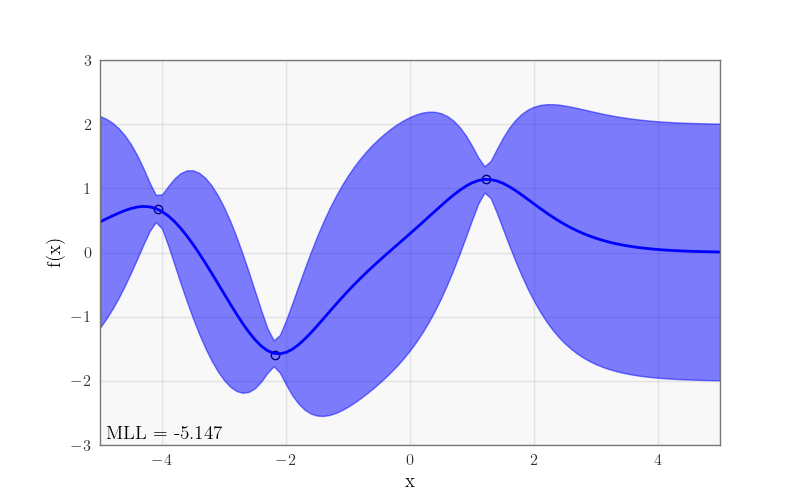

interactive(children=(FloatSlider(value=1.0, description='Lengthscale', max=2.0, min=0.1), FloatSlider(value=1…

In [4]:
train_x = torch.tensor([])
train_y = torch.tensor([])
model = SimpleGP(train_x, train_y)

clearbutton = widgets.Button(description="Reset")
display(clearbutton)
optimizebutton = widgets.Button(description="Optimize")
display(optimizebutton)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlim(test_x.min().item(), test_x.max().item())
ax.set_ylim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')

lengthscale_slider = widgets.FloatSlider(description="Lengthscale", value=1., min=0.1, max=2., step=0.1)
outputscale_slider = widgets.FloatSlider(description="Outputscale", value=1., min=0.1, max=3., step=0.1)
noise_slider = widgets.FloatSlider(description="Noise", value=0.01, min=0.01, max=0.1, step=0.01)


def clear_plot(b):
    global train_x, train_y
    train_x = torch.tensor([])
    train_y = torch.tensor([])
    model.set_train_data(train_x, train_y, strict=False)
    update_plot()


def update_plot(lengthscale=1, outputscale=1, noise=0.01):
    ax.clear()
    model.kernel_function.initialize(outputscale=outputscale)
    model.kernel_function.base_kernel.initialize(lengthscale=lengthscale)
    model.likelihood.initialize(noise=noise)
    
    # Compute marginal log likelihood
    if train_x.numel() > 0:
        with torch.no_grad():
            model.train()
            mll = model.likelihood(model(train_x)).log_prob(train_y).item()
    
    # Compute predictive posterior
    plot_prior = train_x.numel() == 0  # We'll simply plot the GP prior when there's no data
    with torch.no_grad(), gpytorch.settings.prior_mode(plot_prior):
        model.eval()
        prediction = model(test_x)
        mean = prediction.mean
        lower, upper = prediction.confidence_region()

    # Plot predictive posterior
    ax.scatter(train_x, train_y, marker='o', edgecolors='k', color='white')
    mean_line, = ax.plot(test_x.numpy(), mean.numpy(), color='b')
    ax.fill_between(
        test_x.numpy(), lower.numpy(), upper.numpy(),
        color=mean_line.get_color(), alpha=0.5
    )
    ax.set(xlim=[-5., 5.], ylim=[-3., 3.], xlabel="x", ylabel="f(x)")
    
    # Display MLL
    if train_x.numel() > 0:
        ax.text(-4.9, -2.9, f"MLL = {mll:.3f}")


def optimize(event):
    # Only optimize hyperparameters if there's data
    if train_x.numel() == 0:
        return
    
    model.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for i in range(200):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
    lengthscale = min(max(model.kernel_function.base_kernel.lengthscale.item(), 0.1), 2.)
    outputscale = min(max(model.kernel_function.outputscale.item(), 0.1), 3.)
    noise = min(max(model.likelihood.noise.item(), 0.01), 0.5)
    lengthscale_slider.value = lengthscale
    outputscale_slider.value = outputscale
    noise_slider.value = noise
    update_plot(lengthscale=lengthscale, outputscale=outputscale, noise=noise)


def onclick(event):
    global train_x, train_y
    new_x = torch.tensor([event.xdata], dtype=train_x.dtype)
    new_y = torch.tensor([event.ydata], dtype=train_y.dtype)
    train_x = torch.cat([train_x, new_x], 0) if train_x.numel() else new_x
    train_y = torch.cat([train_y, new_y], 0) if train_y.numel() else new_y
    
    model.set_train_data(train_x, train_y, strict=False)
    update_plot()


clearbutton.on_click(clear_plot)
optimizebutton.on_click(optimize)
interact(update_plot, lengthscale=lengthscale_slider, outputscale=outputscale_slider, noise=noise_slider)
update_plot()
cid = fig.canvas.mpl_connect('button_press_event', onclick)